In [1]:
import os
from datetime import datetime
from dateutil.parser import parse
import time

import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pprint import pprint
from tqdm import tqdm

import seaborn as sns
sns.set_theme(style="whitegrid")

from src.nft_analytics import NFTAnalytics
from src.ethereum_api import EthereumAPI

In [2]:
gaa = NFTAnalytics("0xA0F38233688bB578c0a88102A95b846c18bc0bA7")
DATA_FOLDER, RESULT_FOLDER = gaa.make_directories("GreatApeSociety")
TIMESTAMP = datetime.now().strftime("%Y-%m-%d_")

2021-09-25 13:01:02,655 - src.ethereum_api - INFO - Connected to Infura endpoint.


# Fetch all GreatApe data from OpenSea

Note that this can fail if OpenSea decides to rate limit. Works best at night when the load on their servers is low.

In [ ]:
asset_data = gaa.fetch_data(max_offset=10000)
gaa.save_json(asset_data, filename=os.path.join(DATA_FOLDER, "data.json"))

# Load json file

In [3]:
asset_data = gaa.load_json(filename=os.path.join(DATA_FOLDER, "data.json"))
OPENSEA_FLOOR_PRICE = 0.1

## Scatter plot of listing prices with time

In [4]:
created_dates = []
listing_prices = []
for asset in asset_data:
    if asset["sell_orders"]:
        created_dates.append(parse(asset["sell_orders"][0]["created_date"]))
        listing_prices.append(float(asset["sell_orders"][0]["base_price"]) / 1e18)
listing_prices = np.array(listing_prices)

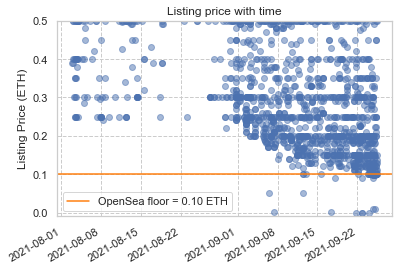

In [39]:
fig, ax = plt.subplots()

dates = matplotlib.dates.date2num(created_dates)
ax.plot_date(dates, listing_prices, 'o', alpha=0.5)
fig.autofmt_xdate()
ax.set_ylim(-0.01, OPENSEA_FLOOR_PRICE * 5)
ax.set_ylabel("Listing Price (ETH)")
ax.axhline(OPENSEA_FLOOR_PRICE, color="tab:orange", linestyle="-", label=f"OpenSea floor = {OPENSEA_FLOOR_PRICE:.2f} ETH")
ax.set_title("Listing price with time")
ax.grid(linestyle="--")
ax.legend()
fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "listing_price_variation_with_time_near_floor.jpg"), bbox_inches="tight", dpi=600)

In [ ]:
# Cost to cleanup sub-floor
np.sum(listing_prices[listing_prices < OPENSEA_FLOOR_PRICE])

## Histogram of listing prices

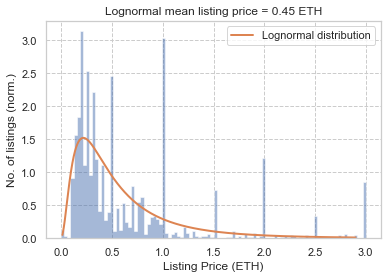

In [18]:
upper_limit = 3

fig, ax = plt.subplots()
_, bins, _ = ax.hist(listing_prices, histtype='stepfilled', density=True, bins=100, range=[0, upper_limit], alpha=0.5)

params = scs.lognorm.fit(listing_prices[listing_prices < upper_limit])
x_bins = np.linspace(1e-2, np.max(listing_prices[listing_prices < upper_limit]), len(bins)*100) 
ax.plot(x_bins, scs.lognorm.pdf(x_bins, *params), linewidth=2, label=f"Lognormal distribution")
ax.set_title(f"Lognormal mean listing price = {params[2]:.2f} ETH")

ax.set_xlabel("Listing Price (ETH)")
ax.set_ylabel("No. of listings (norm.)")
ax.legend()
ax.grid(True, linestyle="--")

fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "histogram_listing_price_variation_near_floor.jpg"), bbox_inches="tight", dpi=600)

# Sale price with time

In [19]:
sale_prices = []
timestamps = []

for asset in asset_data:
    if asset["last_sale"]:
        if asset["last_sale"]["event_type"] == "successful":
            timestamps.append(parse(asset["last_sale"]["transaction"]["timestamp"]))
            sale_prices.append(float(asset["last_sale"]["total_price"]) / 1e18)
            
sale_prices = np.array(sale_prices)

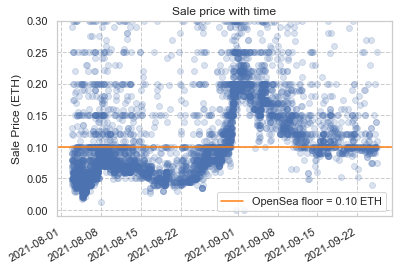

In [27]:
fig, ax = plt.subplots()

dates = matplotlib.dates.date2num(timestamps)
ax.plot_date(dates, sale_prices, 'o', alpha=0.2)
fig.autofmt_xdate()

ax.set_ylim(-0.01, 0.3)
ax.set_ylabel("Sale Price (ETH)")
ax.axhline(OPENSEA_FLOOR_PRICE, color="tab:orange", linestyle="-", label=f"OpenSea floor = {OPENSEA_FLOOR_PRICE:.2f} ETH")
ax.set_title("Sale price with time")
ax.grid(True, linestyle="--")

ax.legend()

fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "sale_price_variation_with_time_near_floor.jpg"), bbox_inches="tight", dpi=600)

# Bar plot of sales

In [21]:
df = pd.DataFrame(columns=["Date", "Sales"])

df["Date"] = sorted(timestamps)
df["Sales"] = np.ones(len(timestamps))
df = df.groupby(df['Date'].dt.date).sum()

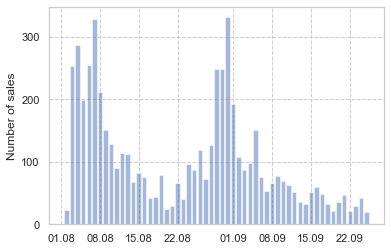

In [25]:
upper_limit = 1

fig, ax = plt.subplots()

ax.bar(df.index, df["Sales"], alpha=0.5)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax.set_ylabel("Number of sales")
ax.set_yticks(ax.get_yticks()[::2])
ax.grid(True, linestyle="--")
fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "histogram_number_of_sales_with_time.jpg"), bbox_inches="tight", dpi=600)

In [ ]:
upper_limit = 1

fig, ax = plt.subplots()

unix_timestamps = []

for times in timestamps:
    unix_timestamps.append(times.timestamp())

mpl_data = mdates.epoch2num(unix_timestamps)
_, bins, _ = ax.hist(mpl_data, bins=50, alpha=0.5)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax.set_ylabel("No. of sales")
ax.grid(False)
fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "histogram_number_of_sales_with_time.jpg"), bbox_inches="tight", dpi=600)

In [ ]:
df.to_excel(os.path.join(RESULT_FOLDER, TIMESTAMP + "sales_by_day.xlsx"), index=True)

# Time histogram of number of sales over a day (defined by timestamps within bin)

In [ ]:
fig, ax = plt.subplots()

hours = []

for times in timestamps:
    hours.append(times.hour)
    
_, bins, _ = ax.hist(hours, bins=24, alpha=0.5)

ax.set_ylabel("No. of sales")
ax.set_xlabel("Time of day in hours (UTC)")
ax.set_yscale("log")
#fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "histogram_number_of_sales_with_time_of_day.jpg"), bbox_inches="tight", dpi=600)

# Median price of traits

In [ ]:
traits = {
    "Clothes" : "Hufflepuff",
    "Eyes": "Orange_Glasses",
    "Fur": "Gold_Skin",
    "Background": "Carolina",
    "Mouth": "Laughing_Mouth",
    "Earring": "Green_Red_Earring",
    "Hat": "Fire_Hair"
}

prices = gaa.get_median_prices(asset_data, traits)
print(f"Average price = {np.average(prices):.2f}, Max price = {np.max(prices):.2f}, Min price = {np.min(prices):.2f}")

# Great Apes held by address (OpenSea API + Infura)

In [ ]:
df = gaa.get_nft_holdings(asset_data, "GreatApes", eth_balances=True)

In [ ]:
df = df.sort_values("GreatApes", ascending=False)

In [ ]:
df.to_excel(os.path.join(RESULT_FOLDER, TIMESTAMP + "ape_holders_addresses_and_holdings.xlsx"), index=False)

In [29]:
df = pd.read_excel(os.path.join(RESULT_FOLDER, TIMESTAMP + "ape_holders_addresses_and_holdings.xlsx"))

In [ ]:
df[df["GreatApes"] >= 5]

# ETH in wallet

Under 100 ETH = 99.86%
Over 100 ETH = 0.14%


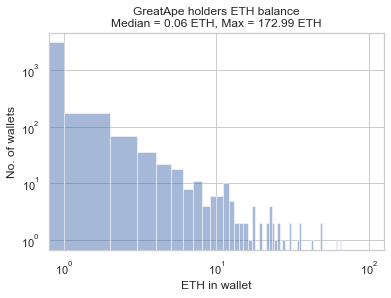

In [30]:
fig, ax = plt.subplots()

upper_limit = 100

_, bins, _ = ax.hist(df["ETH_balance"], density=False, bins=100, alpha=0.5, range=[0, upper_limit], )

print(f"Under {upper_limit} ETH = {len(df['ETH_balance'][df['ETH_balance'] < upper_limit]) / len(df['ETH_balance']) * 100:.2f}%")
print(f"Over {upper_limit} ETH = {len(df['ETH_balance'][df['ETH_balance'] > upper_limit]) / len(df['ETH_balance']) * 100:.2f}%")

ax.set_ylabel("No. of wallets")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("ETH in wallet")

median_holding = np.median(df['ETH_balance'])
max_holding = np.max(df['ETH_balance'])
ax.set_title(f"GreatApe holders ETH balance\nMedian = {median_holding:.2f} ETH, Max = {max_holding:.2f} ETH")

fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "eth_in_holder_wallets.jpg"), bbox_inches="tight", dpi=600)

# Variation of bid price with time

In [ ]:
events_data = gaa.fetch_events(max_offset=10000)

In [ ]:
len(events_data)

In [ ]:
gaa.save_json(events_data, filename=os.path.join(DATA_FOLDER, "events.json"))

In [ ]:
events_data = gaa.load_json(filename=os.path.join(DATA_FOLDER, "events.json"))

In [ ]:
bids = []
created_dates = []

for event in events_data:
    if event["bid_amount"]:
        created_dates.append(parse(event["created_date"]))
        bids.append(float(event["bid_amount"]) / 1e18)
bids = np.array(bids)

In [ ]:
fig, ax = plt.subplots()
#ax.set_yscale("log")
dates = matplotlib.dates.date2num(created_dates)
ax.plot_date(dates, bids, 'o', alpha=0.5)
fig.autofmt_xdate()
ax.set_ylabel("Bid Price (ETH)")
ax.axhline(OPENSEA_FLOOR_PRICE, color="tab:orange", linestyle="--", label="Current OpenSea floor price")
ax.legend()
ax.set_title(f"Variation of bids with time (Bids under floor = {len(bids[bids < 0.06]) / len(bids) * 100:.1f}%)")
#fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "bid_price_variation_with_time.jpg"), bbox_inches="tight", dpi=600)

# Number per price range

In [31]:
created_dates = []
listing_prices = []
for asset in asset_data:
    if asset["sell_orders"]:
        created_dates.append(parse(asset["sell_orders"][0]["created_date"]))
        listing_prices.append(float(asset["sell_orders"][0]["base_price"]) / 1e18)
listing_prices = np.array(listing_prices)

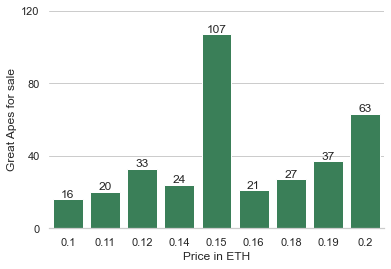

In [32]:
OPENSEA_FLOOR_PRICE = round(OPENSEA_FLOOR_PRICE, 2)

numbers_in_bins = []

price_bins = np.linspace(OPENSEA_FLOOR_PRICE, OPENSEA_FLOOR_PRICE * 2, 9)

last_bin = 0
for current_bin in price_bins:
    number_in_bin = len(listing_prices[(listing_prices < current_bin) & (last_bin < listing_prices)])
    last_bin = current_bin
    numbers_in_bins.append(round(number_in_bin, 2))

price_bins_rounded = np.around(price_bins, 2)

ax = sns.barplot(x=price_bins_rounded, y=numbers_in_bins, color="seagreen")
ax.bar_label(ax.containers[0])
sns.despine(left=True)
ax.set_yticks(ax.get_yticks()[::2])
ax.set_xlabel("Price in ETH")
ax.set_ylabel("Great Apes for sale")
ax.figure.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "great_apes.jpg"), dpi=600)